In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from jax import config
config.update("jax_enable_x64", False)

In [2]:
import OTF, CNF, RealNVP, DatasetGenerator
import numpy as np
import pandas as pd
import optax
import matplotlib.pyplot as plt

from jax import jit, grad, value_and_grad, random
from flax.training import checkpoints

from jax import vmap
import jax.numpy as jnp
from matplotlib import colormaps

2024-05-06 13:15:53.070542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
training_size = 10000
validation_size = 10000
test_size = 20000

In [4]:
BATCH_SIZE_TR = training_size
BATCH_SIZE_VAL_TE = validation_size
EVAL_SOLVER_STEPS = 40

In [5]:
key = random.PRNGKey(seed=42) 

In [6]:
sample = random.normal(key, shape=(2000,2))
sample_colors = random.normal(key, shape=(20,2))

cmap = colormaps['tab20']  #('hsv') #('nipy_spectral')
max_colors = 20
colors = [cmap(color_number / max_colors) for color_number in range(max_colors)]

# CNF

In [7]:
PRECISION_PREFIX = 'float32'
key = random.PRNGKey(seed=42) 

best_params_loss_cnf = checkpoints.restore_checkpoint(
    'checkpoints/finalfinal/CNF_nol2_float32_tuc-logo_3VF_bestparams_loss/checkpoint_20000/checkpoint',
    None)

MODEL = CNF.CNF(
    input_dim=2,
    hidden_dim=64,
    out_dim=2,
    depth=3,
    num_blocks=3,
    key=key,
    f_theta_cls=CNF.f_theta,
    exact_logp=True,     
    num_steps=20
)

In [8]:
stepwise_sample_cnf = MODEL.propagate_with_steps(sample, EVAL_SOLVER_STEPS, params=best_params_loss_cnf)
stepwise_sample_interm_cnf = MODEL.propagate_with_steps(sample_colors, EVAL_SOLVER_STEPS, params=best_params_loss_cnf, intermed_y=True)

# OTF

In [9]:
config.update("jax_enable_x64", True)
PRECISION_PREFIX = 'float64'
key = random.PRNGKey(seed=42) 

best_params_loss_otf = checkpoints.restore_checkpoint(
    'checkpoints/finalfinal/OFT_float64_tuc-logo_3pot_bestparams_loss/checkpoint_20000/checkpoint',
    None)

MODEL = OTF.OTF(
        input_dim=2, 
        hidden_dim=64,
        resnet_depth=2,
        rank=20,
        key=key, 
        phi=OTF.Phi,
        alpha1=15.,
        alpha2=2.,
        num_blocks=3,
        t0=0.,
        t1=1.,
        num_steps=20
)

In [10]:
stepwise_sample_otf = MODEL.propagate_with_steps(sample.astype(jnp.float64), EVAL_SOLVER_STEPS, params=best_params_loss_otf)
stepwise_sample_interm_otf = MODEL.propagate_with_steps(sample_colors.astype(jnp.float64), EVAL_SOLVER_STEPS, params=best_params_loss_otf, intermed_y=True)

# Plot

In [11]:
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize']= 15
plt.rcParams['ytick.labelsize']= 15

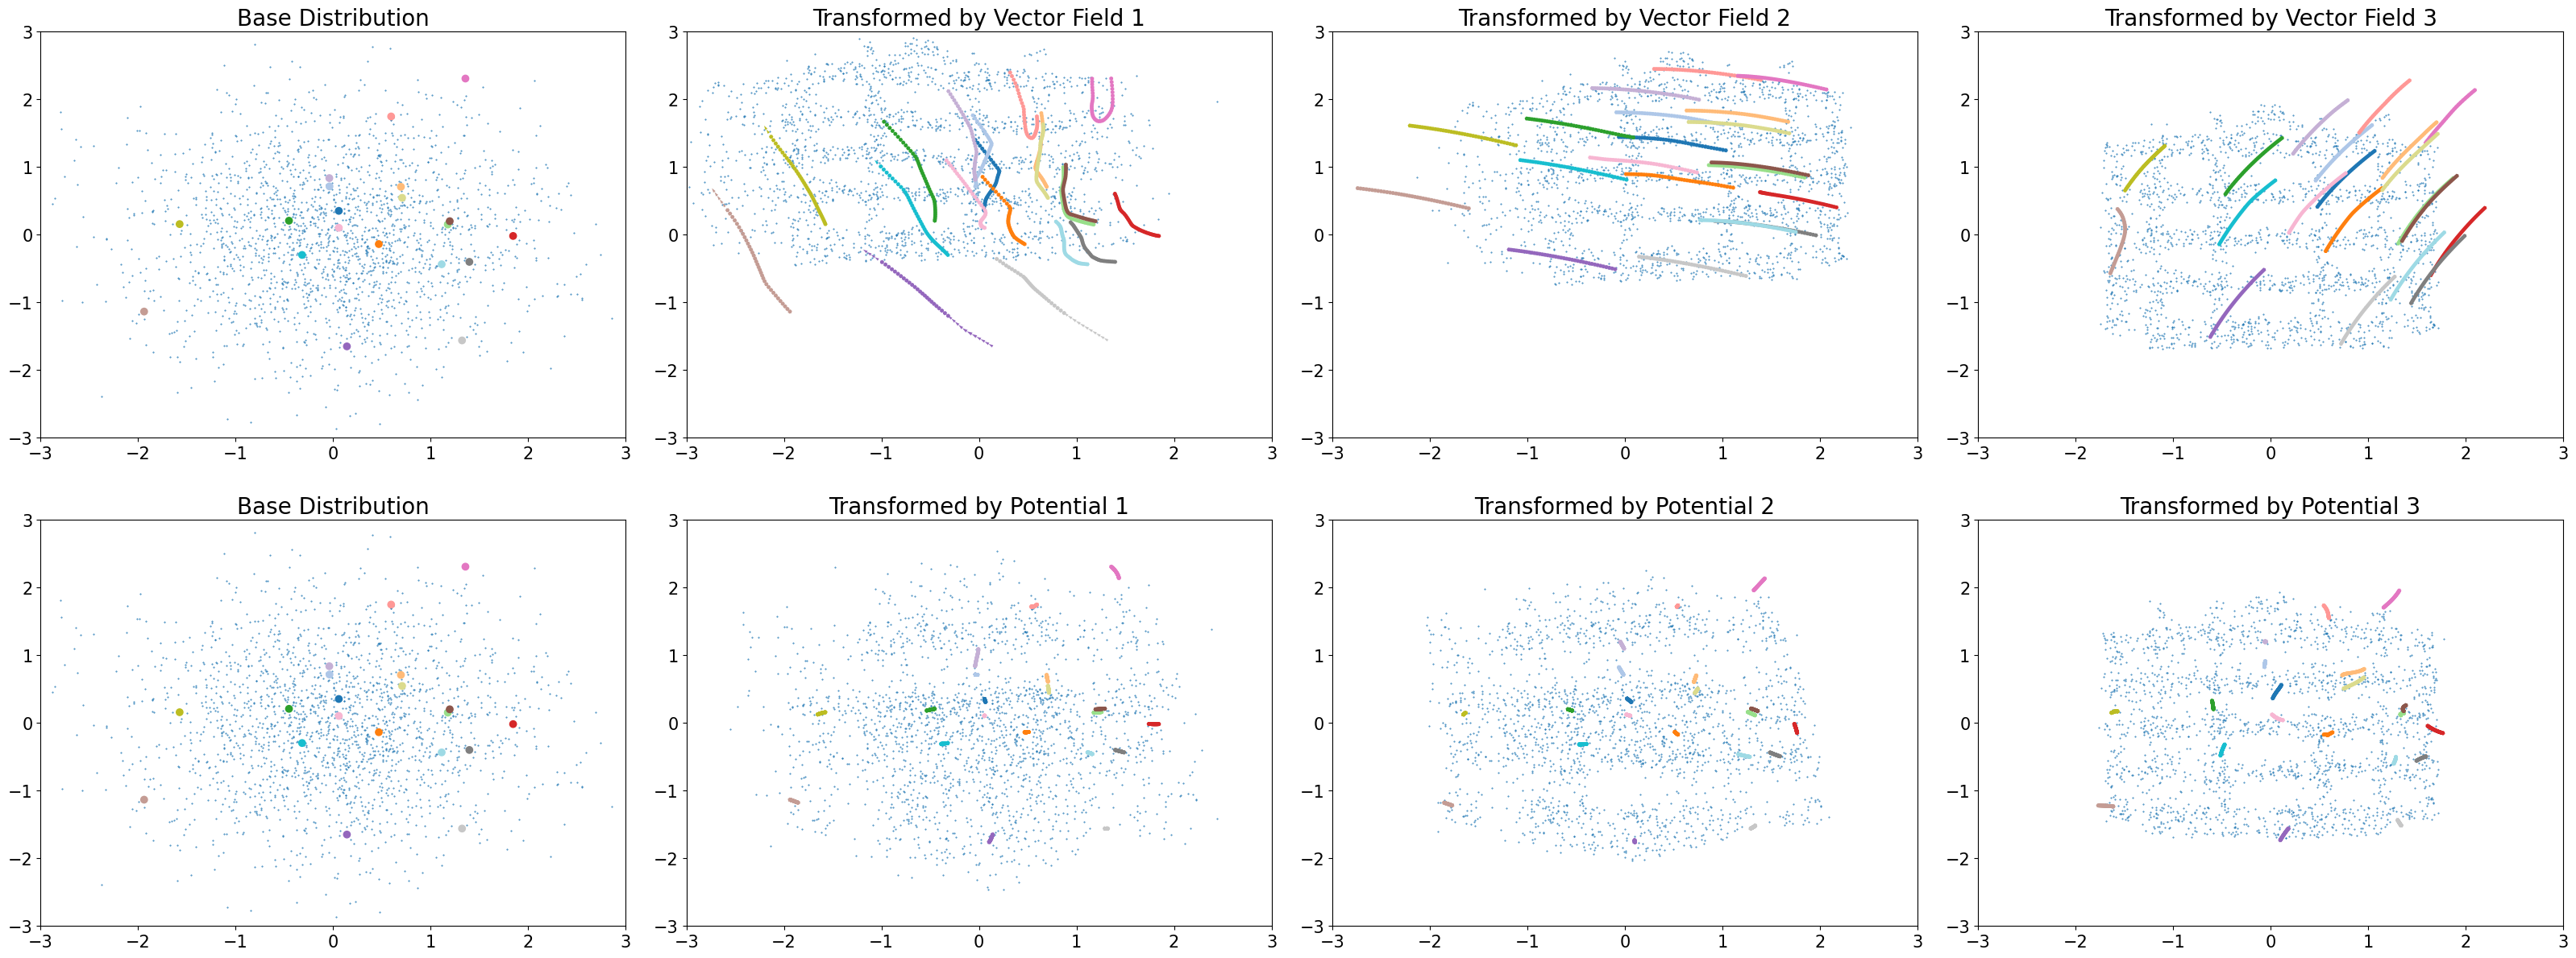

In [12]:
fig3, ax3 = plt.subplots(2,4,figsize=(32,12))
for i in range(4):
    ax3[0, i].scatter(*stepwise_sample_cnf[i].T, s=0.2)
    ax3[1, i].scatter(*stepwise_sample_otf[i].T, s=0.2)

    if i > 0:
        ax3[0, i].set_title(f'Transformed by Vector Field {i}')
        for j_sample in range(20):
            x,y = stepwise_sample_interm_cnf[i][j_sample].T
            ax3[0, i].quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], 
                                scale_units='xy',
                                angles='xy', 
                                scale=1., 
                                color=colors[j_sample])
            x,y = stepwise_sample_interm_otf[i][j_sample].T
            ax3[1, i].set_title(f'Transformed by Potential {i}')
            ax3[1, i].quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], 
                                scale_units='xy',
                                angles='xy', 
                                scale=1., 
                                color=colors[j_sample])
        
ax3[0, 0].set_title(f'Base Distribution')
ax3[0, 0].scatter(*sample_colors.T, c=colors)
ax3[1, 0].set_title(f'Base Distribution')
ax3[1, 0].scatter(*sample_colors.T, c=colors)
plt.tight_layout(h_pad=3)
plt.setp(ax3, xlim=(-3,3), ylim=(-3,3));

In [13]:
fig3.savefig('continous_comparision.png', bbox_inches='tight')

In [14]:
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize']= 15
plt.rcParams['ytick.labelsize']= 15

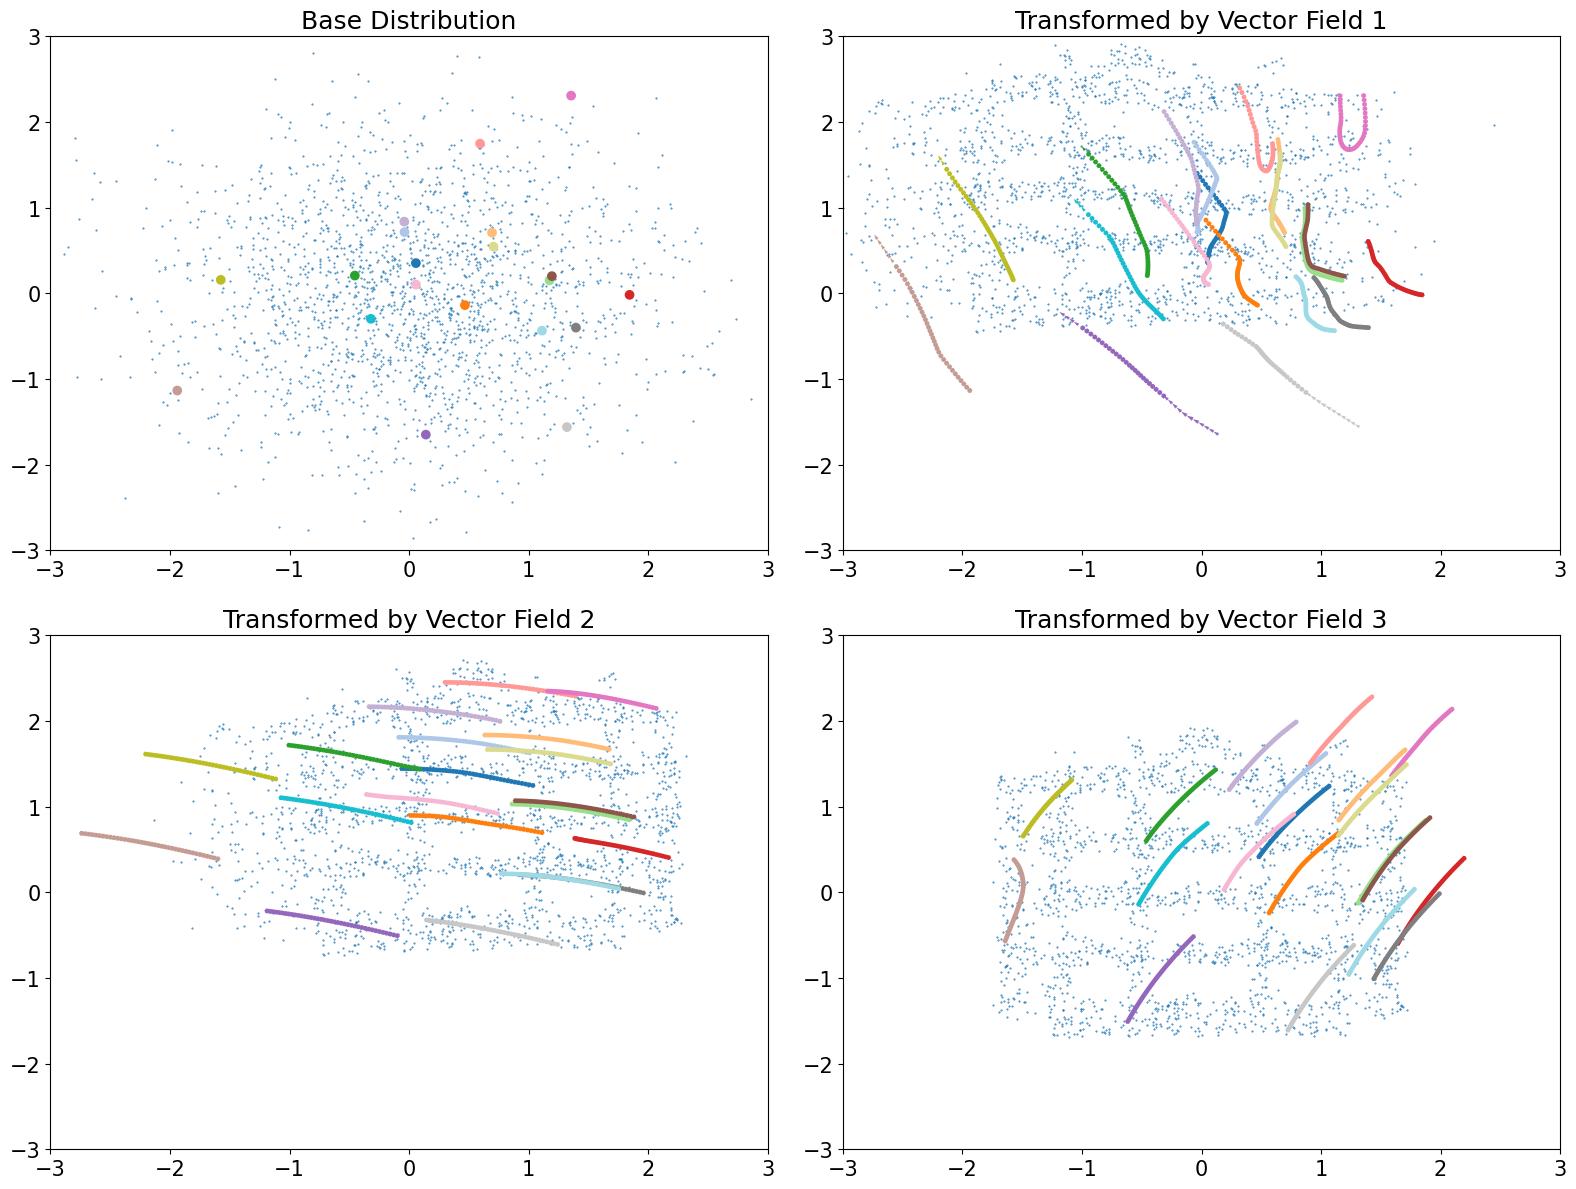

In [19]:
fig3, ax3 = plt.subplots(2,2,figsize=(16,12))
for i in range(4):
    row = i // 2
    col = i % 2
    ax3[row, col].scatter(*stepwise_sample_cnf[i].T, s=0.2)

    if i > 0:
        ax3[row, col].set_title(f'Transformed by Vector Field {i}')
        for j_sample in range(20):
            x,y = stepwise_sample_interm_cnf[i][j_sample].T
            ax3[row, col].quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], 
                                scale_units='xy',
                                angles='xy', 
                                scale=1., 
                                color=colors[j_sample])
        
ax3[0, 0].set_title(f'Base Distribution')
ax3[0, 0].scatter(*sample_colors.T, c=colors)
plt.tight_layout(h_pad=2)
plt.setp(ax3, xlim=(-3,3), ylim=(-3,3));

In [20]:
fig3.savefig('continous_comparision_cnf.png', bbox_inches='tight')

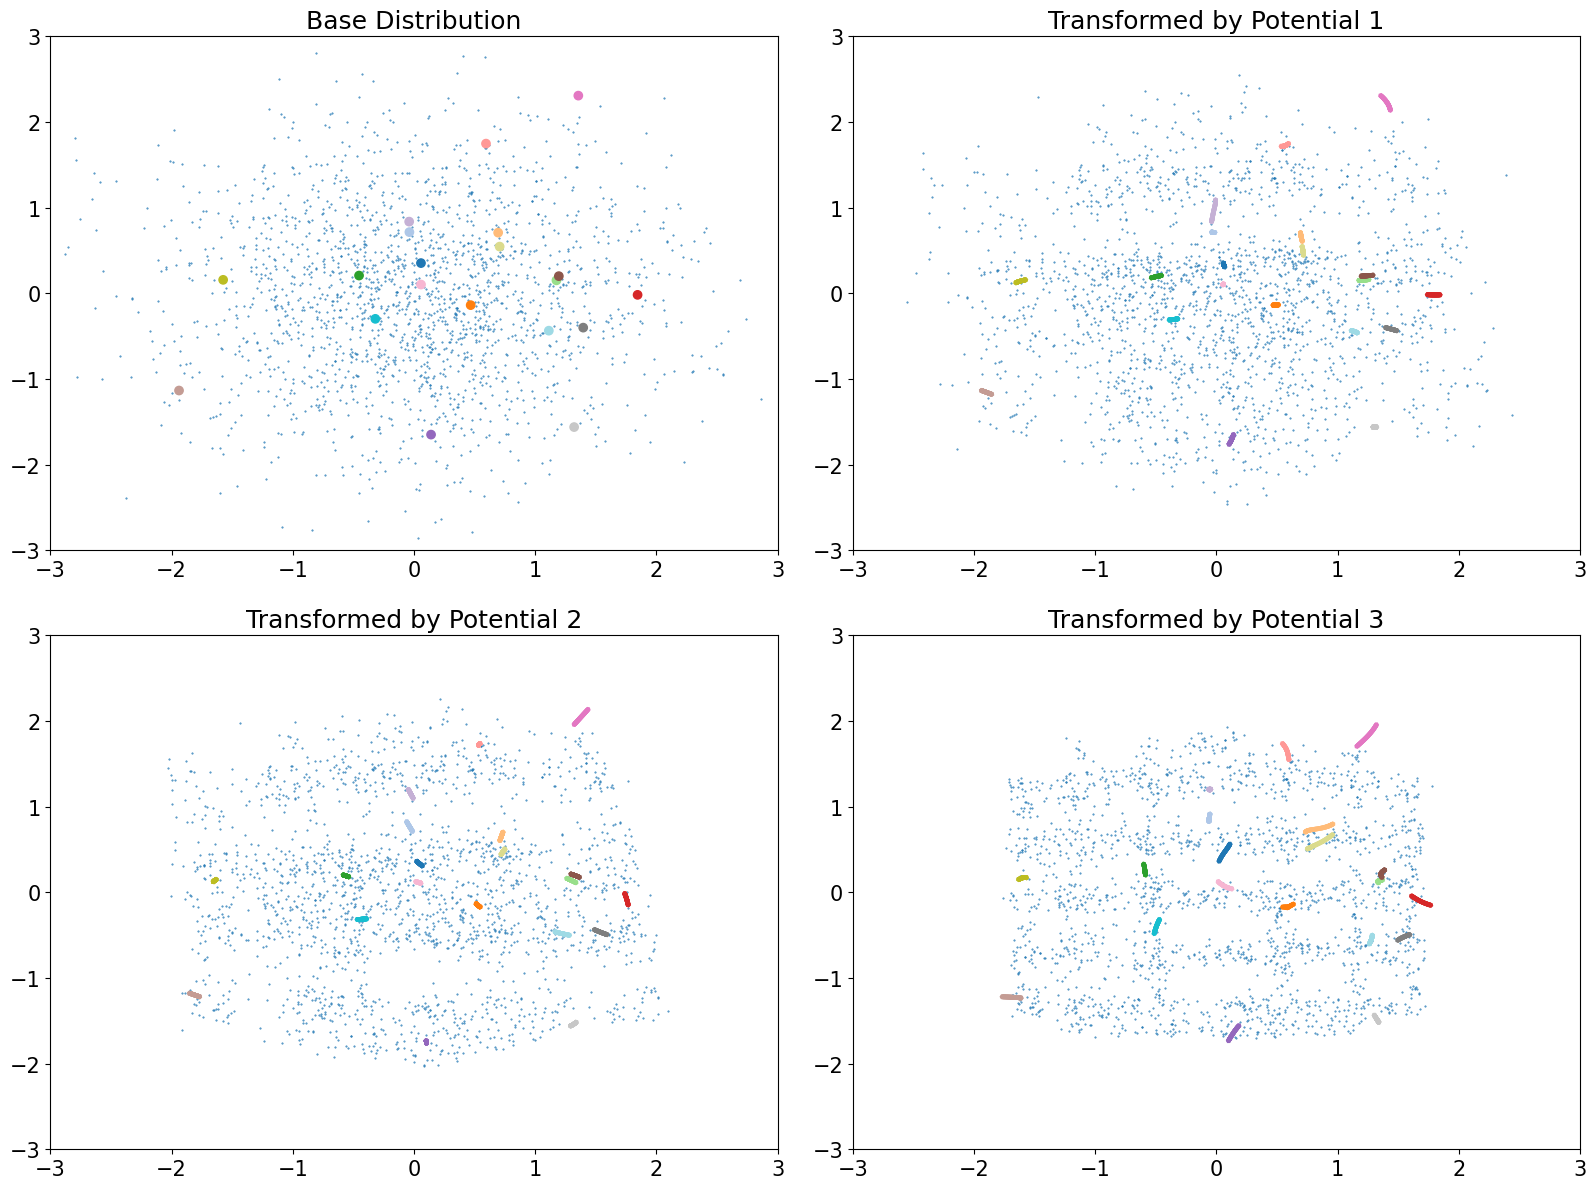

In [21]:
fig3, ax3 = plt.subplots(2,2,figsize=(16,12))
for i in range(4):
    row = i // 2
    col = i % 2
    ax3[row, col].scatter(*stepwise_sample_otf[i].T, s=0.2)

    if i > 0:
        ax3[row, col].set_title(f'Transformed by Potential {i}')
        for j_sample in range(20):
            x,y = stepwise_sample_interm_otf[i][j_sample].T
            ax3[row, col].quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], 
                                scale_units='xy',
                                angles='xy', 
                                scale=1., 
                                color=colors[j_sample])
        
ax3[0, 0].set_title(f'Base Distribution')
ax3[0, 0].scatter(*sample_colors.T, c=colors)
plt.tight_layout(h_pad=2)
plt.setp(ax3, xlim=(-3,3), ylim=(-3,3));

In [22]:
fig3.savefig('continous_comparision_otf.png', bbox_inches='tight')